In [54]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sys.path.append('../src/')
sys.path.append("../../scripts/")
from plt_config import use_latex, TU_GREY, TU_RED
use_latex()
sns.set_palette(plt.rcParams["axes.prop_cycle"].by_key()["color"])


Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [55]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    # val=0.1, # using 80% training / 10 % val / 10% test split
    # test=0.1
)

In [56]:
test_n = [(dataset.molecule(x).natm, x) for x in dataset.test_keys]
test_n = sorted(test_n, key=lambda x: x[0])

In [57]:
from time import time
from pyscf import gto, dft
times = []
basis_functions = []
for basis in ['pcseg-1', 'pcseg-3', 'pcseg-4']:
    print(f"Using basis set: {basis}")
    mol = gto.M(
        atom = """
        O  0.000000   0.000000   0.000000
        H  0.000000  -0.757000   0.587000
        H  0.000000   0.757000   0.587000
        """,
        basis = basis,
        unit  = 'angstrom',
    )

    # set up and run an unrestricted Kohn-Sham DFT

    start_ = time()
    mf = dft.RKS(mol)
    # number orbitals
    basis_functions.append(mol.nao)
    mf.xc = 'B3LYP'        # exchange-correlation functional
    energy = mf.kernel()   # runs the SCF
    end_ = time()
    times.append(1000*(end_ - start_))
print("Times for different basis sets:", times)


Using basis set: pcseg-1
converged SCF energy = -62.2425860094755
Using basis set: pcseg-3
converged SCF energy = -76.4739113641631
Using basis set: pcseg-4
converged SCF energy = -76.4741966214829
Times for different basis sets: [199.08499717712402, 1167.1319007873535, 5221.733331680298]


In [58]:
print(basis_functions)
print(times)
times = times

[24, 126, 223]
[199.08499717712402, 1167.1319007873535, 5221.733331680298]


Polynomial coefficients: [8.21197672e-07 1.51309364e-04 2.16201472e-02 1.27418104e+00
 1.53687293e+02]


/tmp/ipykernel_535029/2759346835.py:2: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(basis_functions, times, 4)


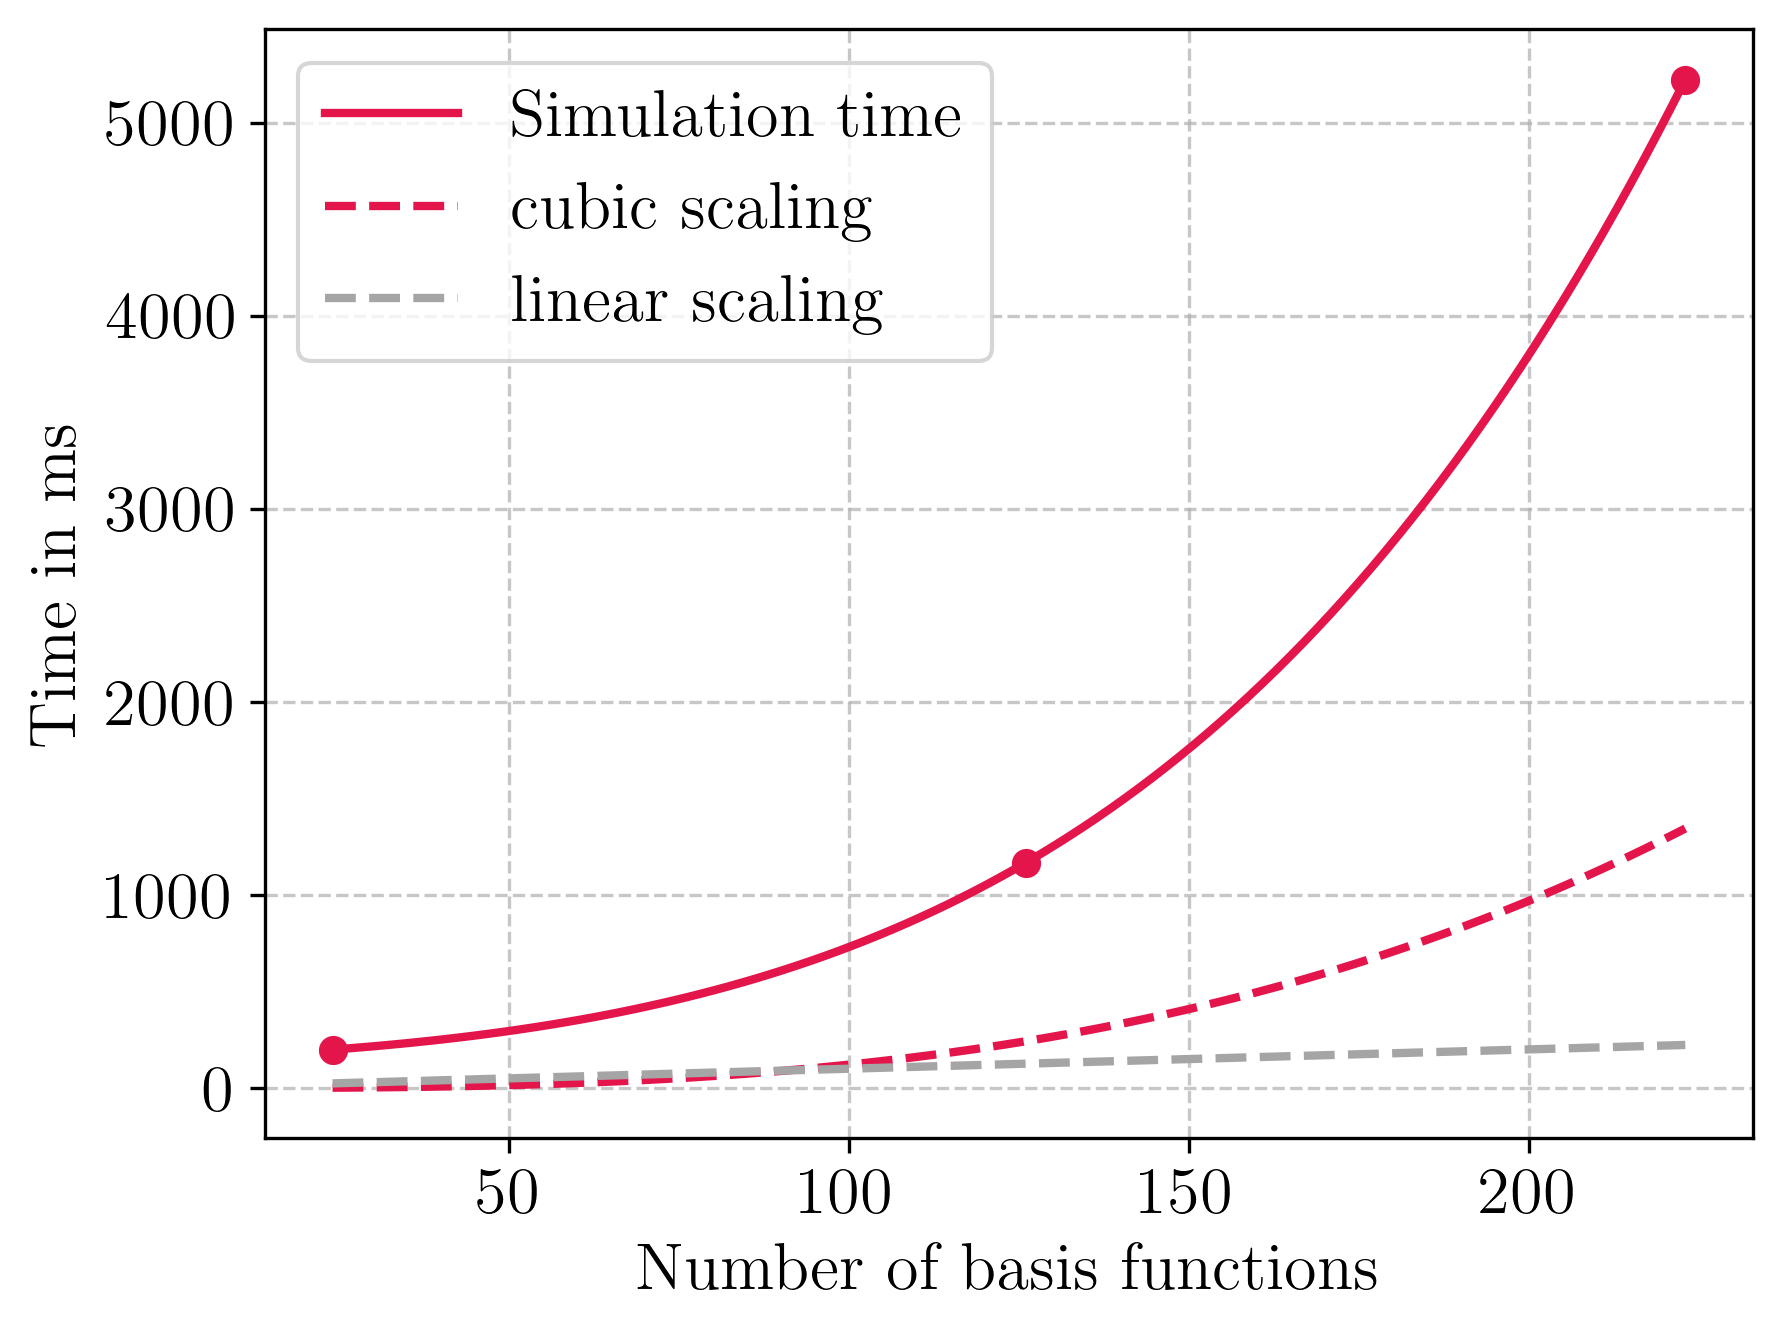

In [85]:
#poly fit
coeffs = np.polyfit(basis_functions, times, 4)
print("Polynomial coefficients:", coeffs)
plt.scatter(basis_functions, times)
x = np.linspace(min(basis_functions), max(basis_functions), 100)
plt.plot(x, np.polyval(coeffs, x), label="Simulation time")
plt.plot(x,1.21197672e-04*x**3, label="cubic scaling", linestyle='--', color=TU_RED)
plt.plot(x,x, label="linear scaling", linestyle='--', color=TU_GREY)
plt.xlabel("Number of basis functions")
plt.ylabel("Time in ms")
plt.legend()

# Gaussians

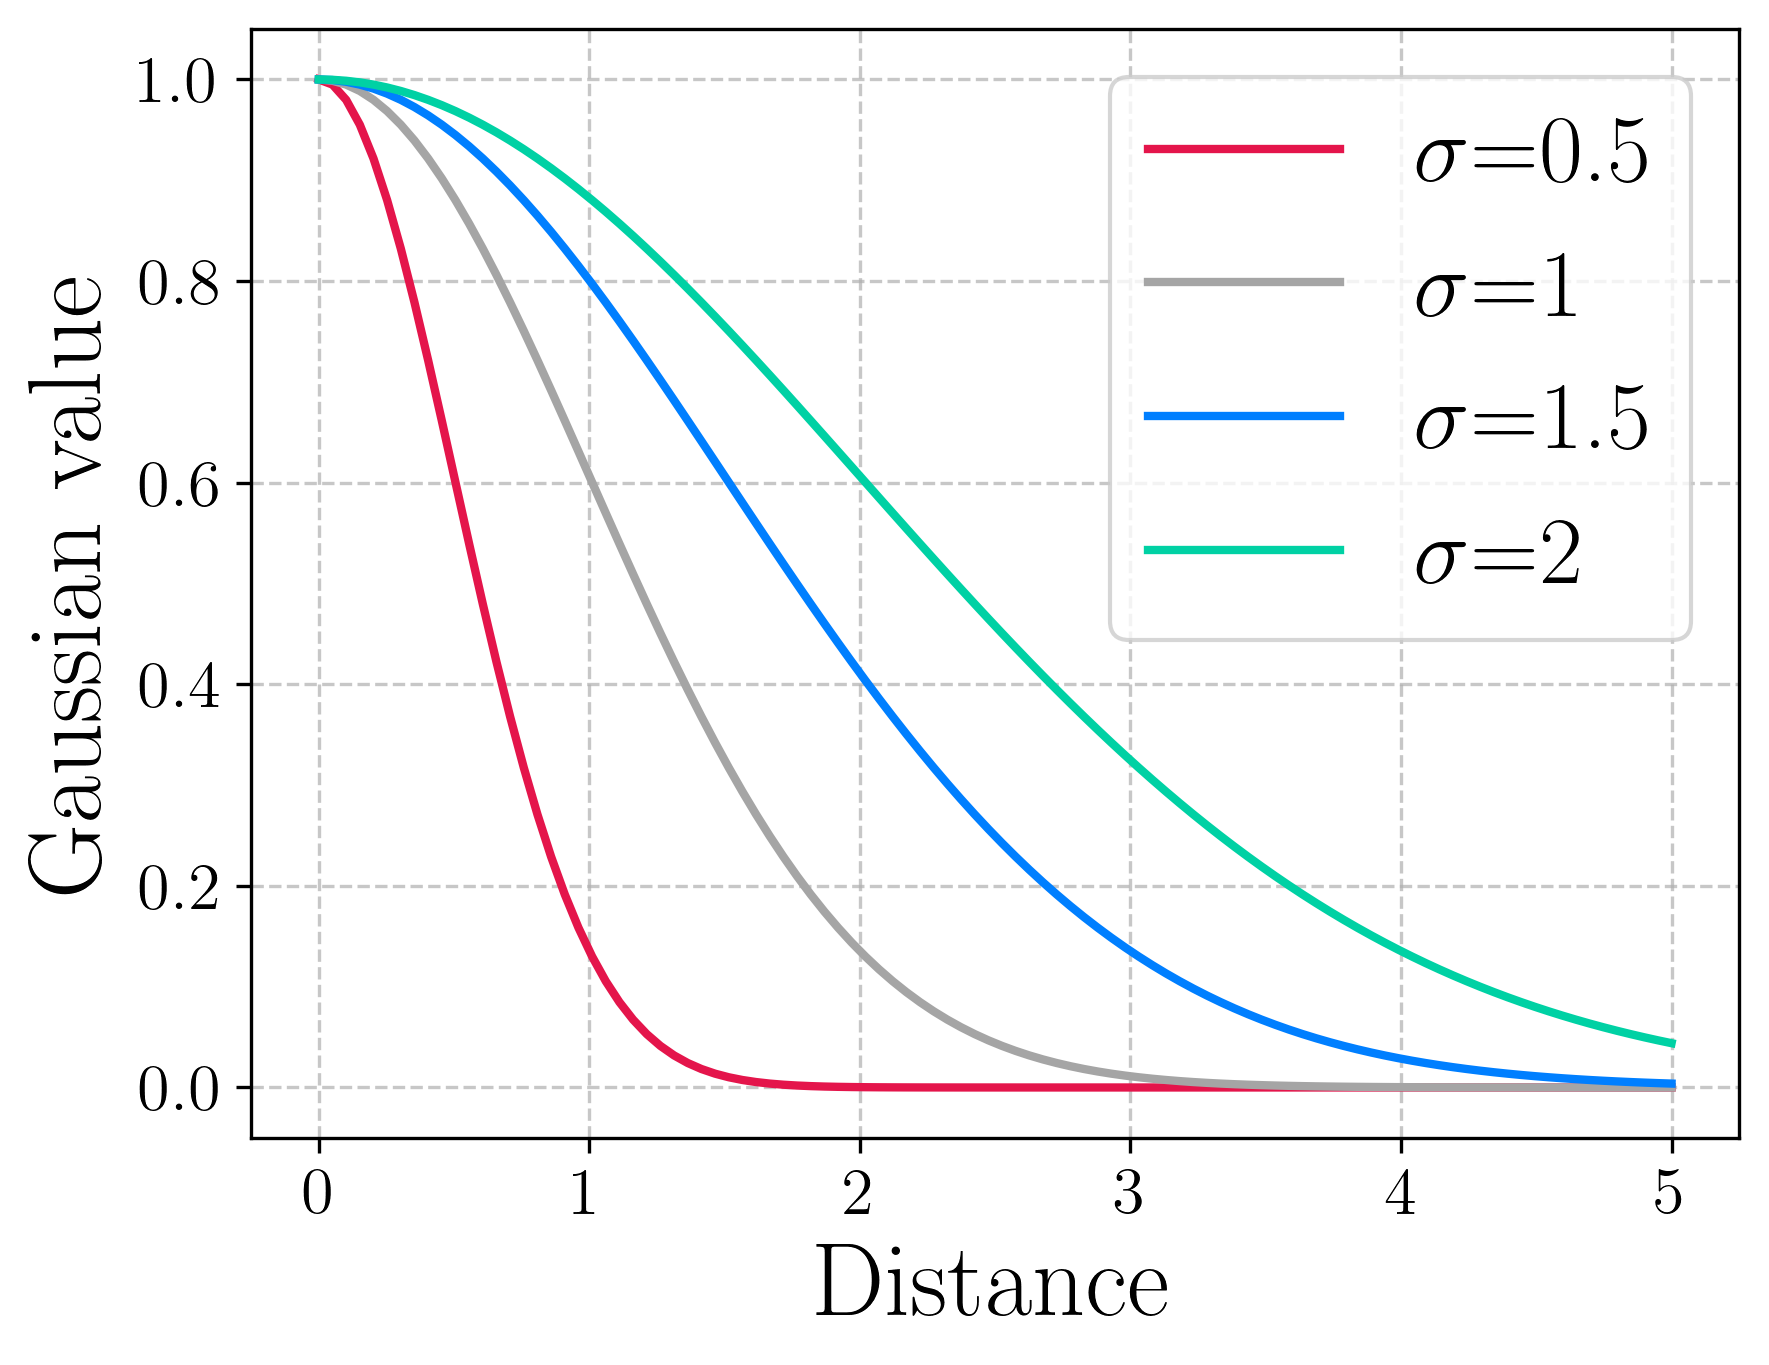

In [94]:
x = np.linspace(0, 5, 100) 
for sigma in [0.5, 1, 1.5, 2]:
    plt.plot(x, np.exp(-x**2/(2*sigma**2)), label=f"$\sigma$={sigma}")
plt.xlabel("Distance", fontsize=25)
plt.ylabel("Gaussian value", fontsize=25)
plt.legend(fontsize=23)